In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2

In [2]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    import matplotlib.pyplot as plt
    plt.figure()

    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="../picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label))


torch.Size([1, 3, 224, 224])
label=388


In [4]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False
    
optimizer = torch.optim.Adam([img])
loss_func = torch.nn.CrossEntropyLoss()

epochs=100
e=0.001

target=288
target=Variable(torch.Tensor([float(target)]).to(device).long())

for epoch in range(epochs):
    
    # forward + backward
    output = model(img)

    loss = loss_func(output, target)
    label=np.argmax(output.data.cpu().numpy())
    
    print("epoch={} loss={} label={}".format(epoch,loss,label))
    
    #如果定向攻击成功
    if label == target:
        print("")
        break
         
    #梯度清零
    optimizer.zero_grad()
    #反向传递 计算梯度   
    loss.backward()
    
    img.data=img.data-e*torch.sign(img.grad.data)


epoch=0 loss=12.659992218017578 label=388
epoch=1 loss=11.617765426635742 label=388
epoch=2 loss=10.683893203735352 label=388
epoch=3 loss=9.859437942504883 label=388
epoch=4 loss=9.151025772094727 label=388
epoch=5 loss=8.530620574951172 label=388
epoch=6 loss=7.9958882331848145 label=388
epoch=7 loss=7.496317386627197 label=388
epoch=8 loss=7.042008876800537 label=388
epoch=9 loss=6.617012023925781 label=388
epoch=10 loss=6.209083080291748 label=388
epoch=11 loss=5.806171417236328 label=388
epoch=12 loss=5.3852033615112305 label=388
epoch=13 loss=4.948579788208008 label=388
epoch=14 loss=4.520714282989502 label=388
epoch=15 loss=4.108192443847656 label=388
epoch=16 loss=3.6978516578674316 label=388
epoch=17 loss=3.306074619293213 label=388
epoch=18 loss=2.943108558654785 label=388
epoch=19 loss=2.5982251167297363 label=290
epoch=20 loss=2.252422332763672 label=290
epoch=21 loss=1.9535226821899414 label=288



(3, 224, 224)


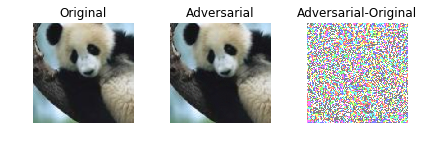

In [6]:
adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

show_images_diff(orig,388,adv,target.data.cpu().numpy()[0])